pyright:  reportUnusedExpression=false

Copyright (c) Microsoft Corporation. All rights reserved. Licensed under the MIT License.

# Capture the Flag Toy Example - Interactive (Human player)

This is a blank instantiaion of the Capture The Flag network to be played interactively by a human player (not via the gym envrionment).
The interface exposed to the attacker is given by the following commands:
    - c2.print_all_attacks()
    - c2.run_attack(node, attack_id)
    - c2.run_remote_attack(source_node, target_node, attack_id)
    - c2.connect_and_infect(source_node, target_node, port_name, credential_id)

In [1]:
import sys, logging
import cyberbattle.simulation.model as model
import cyberbattle.simulation.commandcontrol as commandcontrol
import cyberbattle.samples.toyctf.tinytoy as tty
import plotly.offline as plo

plo.init_notebook_mode(connected=True) # type: ignore
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)s: %(message)s")
%matplotlib inline

In [2]:
network = model.create_network(tty.nodes)
env = model.Environment(
    network=network, vulnerability_library=dict([]), identifiers=tty.ENV_IDENTIFIERS
)
env

Environment(network=<networkx.classes.digraph.DiGraph object at 0x7ffff2fbf5e0>, vulnerability_library={}, identifiers=Identifiers(properties=['CLIENT:Win10', 'CTFFLAG:Readme.txt-Discover secret data', 'MySql', 'Ubuntu', 'nginx/1.10.3'], ports=['HTTPS', 'MySQL', 'SSH'], local_vulnerabilities=['SearchEdgeHistory'], remote_vulnerabilities=['NavigateWebDirectoryFurther', 'ScanPageSource']), creationTime=datetime.datetime(2025, 9, 16, 15, 49, 5, 341306), lastModified=datetime.datetime(2025, 9, 16, 15, 49, 5, 341309), version='0.1.0')

In [3]:
# Copied from cyberbattle/samples/toyctf/tinytoy.py
default_allow_rules = [
    model.FirewallRule("SSH", model.RulePermission.ALLOW),
]
nodes = {
    "Website": model.NodeInfo(
        services=[
            model.ListeningService("SSH", allowedCredentials=["ReusedMySqlCred-web"])
        ],
        firewall=model.FirewallConfiguration(
            incoming=default_allow_rules,
            outgoing=default_allow_rules
            + [
                model.FirewallRule("su", model.RulePermission.ALLOW),
                model.FirewallRule("sudo", model.RulePermission.ALLOW),
            ],
        ),
        value=1000,
        properties=["MySql", "Ubuntu", "nginx/1.10.3"],
        owned_string="FLAG: Login using insecure SSH user/password",
        vulnerabilities=dict(
            ScanPageSource=model.VulnerabilityInfo(
                description="Website page source contains refrence to browseable "
                "relative web directory",
                type=model.VulnerabilityType.REMOTE,
                outcome=model.LeakedNodesId(["Website.Directory"]),
                reward_string="Viewing the web page source reveals a URL to a .txt file and directory on the website",
                cost=1.0,
            ),
        ),
    ),
    "Website.Directory": model.NodeInfo(
        services=[model.ListeningService("HTTPS")],
        value=50,
        properties=[
            "Ubuntu",
            "nginx/1.10.3",
            "CTFFLAG:Readme.txt-Discover secret data",
        ],
        vulnerabilities=dict(
            NavigateWebDirectoryFurther=model.VulnerabilityInfo(
                description="Discover MYSQL credentials MySql for user "
                "'web' in (getting-started.txt)",
                type=model.VulnerabilityType.REMOTE,
                outcome=model.LeakedCredentials(
                    credentials=[
                        model.CachedCredential(
                            node="Website",
                            port="MySQL",
                            credential="ReusedMySqlCred-web",
                        )
                    ]
                ),
                reward_string="Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`"
                "with secret data (aflag); and `getting-started.txt` with MYSQL credentials",
                cost=1.0,
            ),
        ),
    ),
    "client": model.NodeInfo(
        services=[],
        properties=["CLIENT:Win10"],
        value=0,
        vulnerabilities=dict(
            SearchEdgeHistory=model.VulnerabilityInfo(
                description="Search web history for list of accessed websites",
                type=model.VulnerabilityType.LOCAL,
                outcome=model.LeakedNodesId(["Website"]),
                reward_string="Web browser history revealed website URL of interest",
                cost=1.0,
            )
        ),
        agent_installed=True,
        reimagable=False,
    ),
}

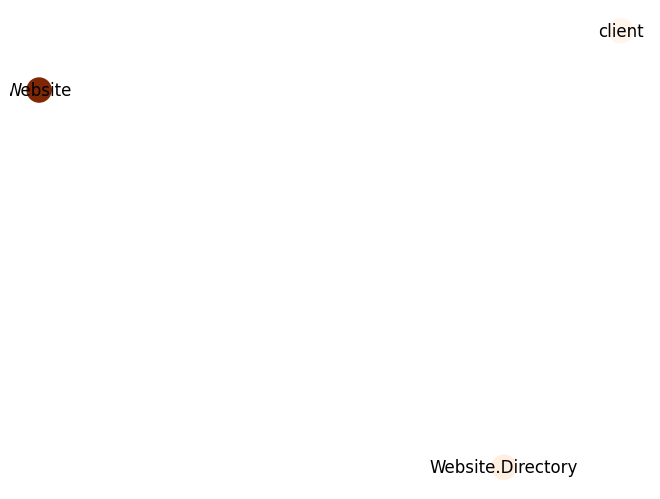

In [4]:
env.plot_environment_graph()

In [5]:
c2 = commandcontrol.CommandControl(env)
dbg = commandcontrol.EnvironmentDebugging(c2)


def plot():
    dbg.plot_discovered_network()
    c2.print_all_attacks()


plot()

,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]


In [6]:
c2.total_reward()

0

In [7]:
c2.print_all_attacks()

,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]


In [8]:
outcome = c2.run_attack("client", "SearchEdgeHistory")
dbg.plot_discovered_network()

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


In [9]:
c2.total_reward()

11.0

In [10]:
c2.print_all_attacks()

,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]
Website,discovered,NaN,None,[ScanPageSource]


In [11]:
# 2
github = c2.run_remote_attack("client", "Website", "ScanPageSource")
dbg.plot_discovered_network()

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


In [12]:
c2.total_reward()

22.0

In [13]:
c2.print_all_attacks()

,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]
Website,discovered,NaN,None,[ScanPageSource]
Website.Directory,discovered,NaN,None,[NavigateWebDirectoryFurther]


In [14]:
# 2
github = c2.run_remote_attack(
    "client", "Website.Directory", "NavigateWebDirectoryFurther"
)
dbg.plot_discovered_network()

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


In [15]:
c2.total_reward()

31.0

In [16]:
c2.print_all_attacks()

,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]
Website,discovered,NaN,None,[ScanPageSource]
Website.Directory,discovered,NaN,None,[NavigateWebDirectoryFurther]


In [17]:
c2.total_reward()

31.0

In [18]:
c2.print_all_attacks()

,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]
Website,discovered,NaN,None,[ScanPageSource]
Website.Directory,discovered,NaN,None,[NavigateWebDirectoryFurther]


In [19]:
c2.connect_and_infect("client", "Website", "SSH", "ReusedMySqlCred-web")

INFO: Infected node 'Website' from 'client' via SSH with credential 'ReusedMySqlCred-web'
INFO: Owned message: FLAG: Login using insecure SSH user/password


True

In [20]:
c2.total_reward()

1031.0

In [21]:
c2.print_all_attacks()

,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]
Website,owned,"[MySql, Ubuntu, nginx/1.10.3]",[],[ScanPageSource]
Website.Directory,discovered,NaN,None,[NavigateWebDirectoryFurther]
